# Subject model in tensorflow

Author: Krzystzof Rusek, AGH University of Science and Technology


In [3]:
!pip install tensorflow_probability

    100% |████████████████████████████████| 512kB 5.6MB/s 


In [0]:
import numpy as np
import numpy.random as rn
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

I assume a simple user models the same as in Lucjan's simulation [Confidence Interval Simulation](https://colab.research.google.com/drive/1h-8hCWy_VWBjBQ2V5Nk5BUWN7g-0ApOp#scrollTo=6qBhGj1PBTq4):
$o_{ij} = \psi_j + \Delta_i + \epsilon_j$

Where $\psi_j \sim U(1-5)$, i.e. it is from uniform distribution. $\Delta_i \sim N(0,b)$, i.e. it is from normal distribution with mean 0 and $b$ is such that the total variance of a single PVS is constant. $\epsilon \sim N(0,a_j)$ so variance is related to PVS but not user, just for simplicity. $a_j$ is driven from Gamma distribution with some parameters. What we know is that the total standard deviation related to specific PVS should be around 0.7-0.8 (Kjell at call at May, 7, 2018). 0.75 will be the mean but distribution makes it possible to have different errors for different cases.

# Notation
https://docs.google.com/document/d/1o7nD2ztvlrhyTAB2eocb92OY2egDBjvrh-pE-zo32tQ/edit

$$U_{ij}=\psi_{j} + \Delta_i + \upsilon_i X + \phi_{j} Y$$

$$X,Y \sim N(0,1)%0$$

## Priors

$\Delta_i \sim N(0,b)$ 

$\psi_j \sim U(1-5)$ 

$\upsilon \sim Gamm(\alpha,\beta)$

$\phi \sim Gamm(\alpha,\beta)$

## Multiple solutions 

According to Jing, the ambiguous solution can be avoided by setting priors on parameters. All we need is to have $\upsilon$ and $\phi$  coming from different distributions

By learning just a MAP, we can avoid MCMC methods and use just an optimization.
For further information check the original document by Jing at the link [Setting constraints to make MLE have single optimal solution](https://docs.google.com/document/d/1QqViBmGDm3Si0hPxH4yXGxn9QjO-ZhIJkURNfSrKcK0/edit)

# MAP Estimator

$$P(\theta|d)=\frac{P(d ,\theta )}{P(d)}=\frac{P(d |\theta ) P(\theta)}{P(d)}$$

MAP estimator finds $$ \hat \theta = argmax_\theta   P(\theta|d)$$.

Going to log probs we have ($P(d)$ is marginalized over $\theta$ and can be ommited):
$$
\log P(\theta|d) = \log P(d |\theta ) + \log P(\theta) - \log P(d)
$$

This is just loglikelihood $ll=\log P(d |\theta )$ plus regularization given by log prior $\log P(\theta)$.

If we assume 

1. $\upsilon \sim Gamm(\alpha_1,\beta_1)$
1. $\phi \sim Gamm(\alpha_2,\beta_2)$

the posterior distribution is given by ([Gamma log-likelihood](https://en.wikipedia.org/wiki/Gamma_distribution#Maximum_likelihood_estimation))

$$
\log P(\theta|d) = ll + I(\alpha_1-1)\overline{\log(\upsilon_i)} -I \frac{\bar \upsilon_i}{\beta_1} + J (\alpha_2-1)\overline{\log(\phi_j)} -J \frac{\bar \phi_j}{\beta_2} + \ldots
$$

We know that maximum of $ll$ is not unique under transformations..., however, log prior does not have such symmetry.
In other words, the internal degree of freedom in log likelihood is fixed by prior assumptions about parameters that serve as constraints.

In [0]:
nPVS = 160 # number of PVSs
nSub = 24 # number of Subjects

std = 0.75 # it is standard deviation for typical PVS
alpha = 30.0 # it is parameter of the gamma distribution from which the variances are generated 
b = 0.3 # standard deviation for delta distribution

psi = rn.uniform(1,5, size=(nPVS,1)) # MOSs generation
fi = rn.gamma(alpha, np.sqrt(0.5*(std**2 - b**2))/alpha, size=(nPVS,1)) # std per PVS with delta
upsilon = rn.gamma(alpha, np.sqrt(0.5*(std**2 - b**2))/alpha, size=(1,nSub)) # std per PVS with delta
Delta = rn.normal(0, b, size=(1,nSub)) # Delta generation 


# Notes

1. Prior improve estimation
1. Estimating continous model from quantized distribution is the most robus, $\Delta$ is biased
1. Hand coded log joint probability, `tfp.edward2.make_log_joint` alows for infering continous score
1. Full Bayess is just one step ahead: MCMC, or StochasticGradientLangevinDynamics
1. $\infty$ in loss, but converges !


## TODO

1. [ ] Test various optimizers
1. [ ] Fisher information matrix as Hessian approximation? GradientDescent works quite well
1. [ ] Proper multinomial distribution for test results (hancoded mapping for continous score)
1. [ ] Hack Optimizer for `tf.float64`
1. [ ] Move this to github

# Generative model

The code uses Edwart2 probabilistic programming language from [tensorflow_probability](https://github.com/tensorflow/probability) package

In [6]:
g = tf.Graph()
with g.as_default():
    tf_delta = tf.Variable(Delta.astype(np.float32))
    tf_psi = tf.Variable(psi.astype(np.float32))

    loc = tf_delta + tf_psi
    
    #make sure std is always positive
    
    tf_upsilon_sqr = tf.Variable(np.sqrt(upsilon).astype(np.float32))
    tf_upsilon = tf_upsilon_sqr**2
    
    tf_fi_sqr = tf.Variable(np.sqrt(fi).astype(np.float32))
    tf_fi = tf_fi_sqr**2
    
    scale = tf.sqrt(tf_upsilon**2 + tf_fi**2)
    o = tfp.edward2.Normal(loc=loc,scale=scale)
    o = tfp.edward2.QuantizedDistribution(o.distribution, low=1.0, high=5.0)


with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    o_val, = sess.run([o])
    print(o_val)

[[2. 1. 3. ... 1. 3. 3.]
 [1. 2. 3. ... 4. 3. 2.]
 [5. 4. 5. ... 4. 5. 3.]
 ...
 [2. 4. 4. ... 3. 4. 2.]
 [1. 2. 1. ... 2. 1. 3.]
 [5. 4. 5. ... 5. 5. 5.]]


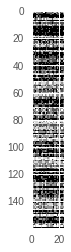

In [7]:
plt.imshow(o_val/5)

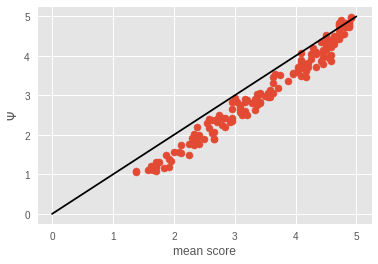

In [8]:
plt.scatter(np.mean(o_val,axis=1),psi)
plt.plot([0,5],[0,5],'k')
plt.xlabel('mean score')
plt.ylabel(r'$\Psi$');

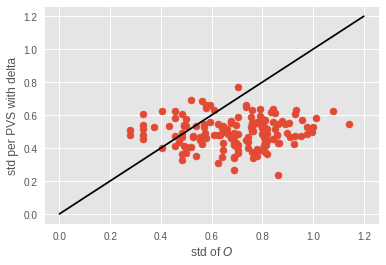

In [9]:
plt.scatter(np.std(o_val,axis=1),fi)
plt.plot([0,1.2],[0,1.2],'k')
plt.xlabel('std of $O$')
plt.ylabel(r'std per PVS with delta');

Let us now use the generative code for inference with  $\Delta$,  $\psi$ ,$\upsilon$ and $\phi$ as variables


* Distribution of $O_{ij}$ is quantized normal implemeted using  ```tfp.edward2```
* MLE is obtained by minimizing negative log_prob.
* Initial condition from moments estimators
* MAP is just MLE with prior loglik as regularization 

In [10]:
g = tf.Graph()
with g.as_default():
    
    #Plausible initial conditions
    psi_in = rn.uniform(1,5, size=(nPVS,1)) # MOSs generation
    fi_in = rn.gamma(alpha, np.sqrt(0.5*(std**2 - b**2))/alpha, size=(nPVS,1)) # std per PVS with delta
    upsilon_in = rn.gamma(alpha, np.sqrt(0.5*(std**2 - b**2))/alpha, size=(1,nSub)) # std per PVS with delta
    Delta_in = rn.normal(0, b, size=(1,nSub)) # Delta generation 

    # Copy-Paste
    # TODO move this to function
    
    tf_delta = tf.Variable(Delta_in.astype(np.float32))
    tf_psi = tf.Variable(psi_in.astype(np.float32))

    loc = tf_delta + tf_psi
    
    #make sure std is always positive
    
    tf_upsilon_sqr = tf.Variable(np.sqrt(upsilon_in).astype(np.float32))
    tf_upsilon = tf_upsilon_sqr**2
    
    tf_fi_sqr = tf.Variable(np.sqrt(fi_in).astype(np.float32))
    tf_fi = tf_fi_sqr**2
    
    scale = tf.sqrt(tf_upsilon**2 + tf_fi**2)
    
    
    o = tfp.edward2.Normal(loc=loc,scale=scale)
    o = tfp.edward2.QuantizedDistribution(o.distribution.copy(), low=np.float32(1.0), high=np.float32(5.0))
    
    loglik = tf.reduce_mean(o.distribution.log_prob(o_val))
    
    delta_prior = tfp.edward2.Normal(loc=0.0,scale=0.3)
    psi_prior = tfp.edward2.Uniform(low=1.0,high=5.0)
    #the same for fi
    upsilon_prior = tfp.edward2.Gamma(
        concentration=np.float32(alpha),
        rate=np.float32(alpha/np.sqrt(0.5*(std**2 - b**2))))
    
#     delta_prior = tfp.edward2.Normal(loc=np.zeros((1,nSub), dtype=np.float32) ,scale=0.3,name="delta")
#     psi_prior = tfp.edward2.Uniform(low=np.ones((nPVS,1),dtype=np.float32), high=5.0,name="psi")
#     #the same for fi
#     upsilon_prior = tfp.edward2.Gamma(
#         concentration=np.float32(alpha)*np.ones((1,nSub),dtype=np.float32),
#         rate=np.float32(alpha/np.sqrt(0.5*(std**2 - b**2))),name="upsilon")
#     fi_prior = tfp.edward2.Gamma(
#         concentration=np.float32(alpha)*np.ones((nPVS,1),dtype=np.float32),
#         rate=np.float32(alpha/np.sqrt(0.5*(std**2 - b**2))),name="fi")
    
    prior_log_prob = tf.reduce_sum(delta_prior.distribution.log_prob(tf_delta)) + \
        tf.reduce_sum(psi_prior.distribution.log_prob(tf_psi)) + \
        tf.reduce_sum(upsilon_prior.distribution.log_prob(tf_upsilon)) + \
        tf.reduce_sum(upsilon_prior.distribution.log_prob(tf_fi)) # not an erro

    #regularization =   tf.reduce_sum(tf_delta**2)/(2*0.3**2)
    #regularization =   - tf.reduce_sum(delta_prior.distribution.log_prob(tf_delta))/160.0
    #loss = loss + regularization
    loss = -loglik - prior_log_prob/(160.0*24.0)

    #regularization = tf.reduce_sum(delta_prior.distribution.log_prob(tf_delta))
        
    gs=tf.contrib.training.get_or_create_eval_step()
#    lr = tf.train.exponential_decay(0.1,gs,decay_steps=100,decay_rate=0.9999)
#    train_op = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(-loss, global_step=gs)
    
    # to jest bardzo dobre
    train_op = tf.train.RMSPropOptimizer(learning_rate=0.0008).minimize(loss)
    #train_op = tf.train.AdagradOptimizer(learning_rate=0.01).minimize(loss)
    train_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    for i in range(50000):
        _,np_loss,np_reg = sess.run([train_op,loss,prior_log_prob])
        if i % 500 ==0:
            print(i,np_loss,np_reg)
    (delta_hat, 
     psi_hat, 
     upsilon_hat, 
     fi_hat, 
     loss_val) = sess.run([tf_delta,tf_psi,tf_upsilon,tf_fi,loss])


0 3.4683697 -43.97461
500 1.9621689 -462.44354
1000 1.9082712 -572.8662
1500 1.8826634 -585.9284
2000 1.8609641 -573.0385
2500 1.8406986 -553.8923
3000 1.82128 -534.03455
3500 1.8024325 -514.87317
4000 1.7839884 -496.63647
4500 1.765835 -479.239
5000 1.747887 -462.55054
5500 1.7300777 -446.44788
6000 1.712357 -430.82916
6500 1.6946832 -415.61172
7000 1.6770197 -400.73865
7500 1.6593412 -386.154
8000 1.6416235 -371.8225
8500 1.6238499 -357.71298
9000 1.6060075 -343.79926
9500 1.5880885 -330.07153
10000 1.5700897 -316.51782
10500 1.5520121 -303.13245
11000 1.5338567 -289.9151
11500 1.5156332 -276.8666
12000 1.4973515 -263.98926
12500 1.4790212 -251.29213
13000 1.4606628 -238.77945
13500 1.4422982 -226.462
14000 1.4239438 -214.34814
14500 1.4056232 -202.45026
15000 1.3873674 -190.77202
15500 1.3692 -179.32886
16000 1.3511508 -168.12958
16500 1.333249 -157.18599
17000 1.3155252 -146.50725
17500 1.2980087 -136.10434
18000 inf -inf
18500 inf -inf
19000 inf -inf
19500 inf -inf
20000 inf -inf


# Edward2 log_joint

In [0]:
def subject_model():
    delta_prior = tfp.edward2.Normal(loc=np.zeros((1,nSub), dtype=np.float32) ,scale=0.3,name="delta")
    psi_prior = tfp.edward2.Uniform(low=np.ones((nPVS,1),dtype=np.float32), high=5.0,name="psi")
    #the same for fi
    upsilon_prior = tfp.edward2.Gamma(
        concentration=np.float32(alpha)*np.ones((1,nSub),dtype=np.float32),
        rate=np.float32(alpha/np.sqrt(0.5*(std**2 - b**2))),name="upsilon")
    fi_prior = tfp.edward2.Gamma(
        concentration=np.float32(alpha)*np.ones((nPVS,1),dtype=np.float32),
        rate=np.float32(alpha/np.sqrt(0.5*(std**2 - b**2))),name="fi")
    
    
    n = tfp.edward2.Normal(loc=delta_prior + psi_prior,
                         scale=tf.sqrt(upsilon_prior**2 + fi_prior**2), name="n")
    #o = tfp.edward2.QuantizedDistribution(n.distribution, low=1.0, high=5.0, name="o")
    return o

def subject_model2():
    delta = tfp.edward2.Normal(loc=0.0,scale=0.3, 
                               sample_shape=(1,nSub),
                              name="delta")

    psi = tfp.edward2.Uniform(low=1.0, high=5.0, 
                              sample_shape=(nPVS,1),
                             name="psi")

    upsilon = tfp.edward2.Gamma(
        concentration=float(alpha),
        rate=float(alpha/np.sqrt(0.5*(std**2 - b**2))),
        sample_shape=(1,nSub),
        name="upsilon")
    
    fi = tfp.edward2.Gamma(
        concentration=float(alpha),
        rate=float(alpha/np.sqrt(0.5*(std**2 - b**2))),
        sample_shape=(nPVS,1),name="fi")
    
    
    o = tfp.edward2.Normal(loc=delta + psi,
                         scale=tf.sqrt(upsilon**2 + fi**2), name="o")
    
    #o2 = tfp.edward2.QuantizedDistribution(o.distribution, low=1.0, high=5.0,name='o2')
    return o#2


g = tf.Graph()
with g.as_default():

    psi_in = rn.uniform(1,5, size=(nPVS,1)) # MOSs generation
    fi_in = rn.gamma(alpha, np.sqrt(0.5*(std**2 - b**2))/alpha, size=(nPVS,1)) # std per PVS with delta
    upsilon_in = rn.gamma(alpha, np.sqrt(0.5*(std**2 - b**2))/alpha, size=(1,nSub)) # std per PVS with delta
    Delta_in = rn.normal(0, b, size=(1,nSub)) # Delta generation 

   
    tf_delta = tf.Variable(Delta_in.astype(np.float32))
    tf_psi = tf.Variable(psi_in.astype(np.float32))
    
    tf_upsilon_sqr = tf.Variable(np.sqrt(upsilon_in).astype(np.float32))
    tf_upsilon = tf_upsilon_sqr**2
    
    tf_fi_sqr = tf.Variable(np.sqrt(fi_in).astype(np.float32))
    tf_fi = tf_fi_sqr**2

    #oo=subject_model2()
    log_joint = tfp.edward2.make_log_joint_fn(subject_model2)
    
    opreq = tf.get_variable('opreq',shape=o_val.shape,dtype=o_val.dtype)
    
    loss = -log_joint(delta=tf_delta,
                     psi = tf_psi,
                     upsilon = tf_upsilon,
                     fi=tf_fi,
                     #o=opreq,
                     o=o_val)
    #train_op = tf.train.RMSPropOptimizer(learning_rate=0.0008).minimize(loss)
    #train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)
    train_op = tf.train.AdagradOptimizer(learning_rate=0.01).minimize(loss)
        
with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    for i in range(100000):
        _,np_loss = sess.run([train_op,loss])
        if i % 1000 ==0:
            print(i,np_loss)
    (delta_hat, 
     psi_hat, 
     upsilon_hat, 
     fi_hat, 
     loss_val) = sess.run([tf_delta,tf_psi,tf_upsilon,tf_fi,loss])


0 15879.487
1000 7207.7534
2000 6669.2793
3000 6272.5405
4000 5943.595
5000 5666.5127
6000 5432.886
7000 5235.42
8000 5067.6055
9000 4924.016
10000 4800.327
11000 inf
12000 inf
13000 inf
14000 inf
15000 inf
16000 inf
17000 inf
18000 inf
19000 inf
20000 inf
21000 inf
22000 inf
23000 inf
24000 inf
25000 inf
26000 inf
27000 inf
28000 inf
29000 inf
30000 inf
31000 inf
32000 inf
33000 inf
34000 inf
35000 inf
36000 inf
37000 inf
38000 inf
39000 inf
40000 inf
41000 inf
42000 inf
43000 inf
44000 inf
45000 inf
46000 inf
47000 inf
48000 inf
49000 inf
50000 inf
51000 inf
52000 inf
53000 inf
54000 inf
55000 inf
56000 inf
57000 inf
58000 inf
59000 inf
60000 inf
61000 inf
62000 inf
63000 inf
64000 inf
65000 inf
66000 inf
67000 inf
68000 inf
69000 inf
70000 inf
71000 inf
72000 inf
73000 inf
74000 inf
75000 inf
76000 inf
77000 inf
78000 inf
79000 inf
80000 inf
81000 inf
82000 inf
83000 inf
84000 inf
85000 inf
86000 inf
87000 inf
88000 inf
89000 inf
90000 inf
91000 inf
92000 inf
93000 inf
94000 inf
950

In [0]:
from tensorflow_probability import edward2 as ed

def model():
      w = ed.Normal(loc=0., scale=1., sample_shape=, name="w")
      y = ed.Normal(loc=tf.tensordot(X, w, [[1], [0]]), scale=0.1, name="y")
      return y

g = tf.Graph()
with g.as_default():
    log_joint = ed.make_log_joint_fn(model)

    X = tf.random_normal([3, 2])
    w_value = tf.random_normal([2])
    y_value = tf.random_normal([3])
    output = log_joint(X, w=w_value, y=y_value)

with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    print(output.eval())

-170.40956


In [0]:
o_val

array([[2.062582  , 1.675439  , 3.6083555 , ..., 2.2330341 , 1.8872852 ,
        3.309371  ],
       [4.749155  , 4.625428  , 5.6094723 , ..., 4.5532784 , 5.0379214 ,
        4.532455  ],
       [1.8878939 , 0.24163139, 1.8553929 , ..., 3.207556  , 0.5289407 ,
        3.0511765 ],
       ...,
       [1.2356493 , 0.35133523, 0.96680534, ..., 1.3648292 , 2.4586809 ,
        1.3481271 ],
       [4.6968946 , 4.695248  , 5.750748  , ..., 4.6108055 , 5.394107  ,
        3.8911562 ],
       [4.1741877 , 3.2330506 , 4.179968  , ..., 3.749391  , 5.2108755 ,
        3.5042892 ]], dtype=float32)

In [0]:
1/(24*160)

0.00026041666666666666

Text(0,0.5,'Recovered score')

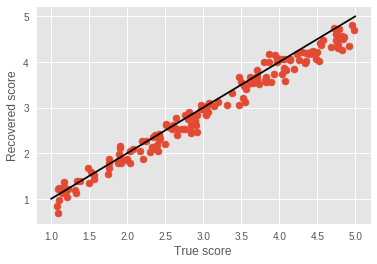

In [11]:
plt.scatter(psi,psi_hat)
plt.plot([1,5],[1,5],'k')
plt.xlabel('True score')
plt.ylabel('Recovered score')

Text(0,0.5,'Recovered bias')

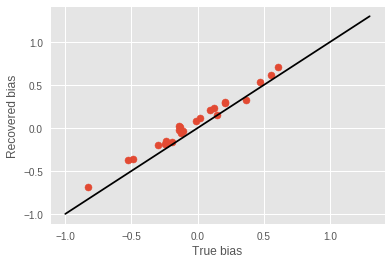

In [12]:
plt.scatter(Delta,delta_hat)
plt.plot([-1,1.3],[-1,1.3],'k')
plt.xlabel('True bias')
plt.ylabel('Recovered bias')

Text(0,0.5,'Recovered std')

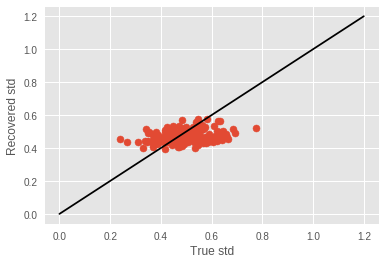

In [13]:
plt.scatter(fi,fi_hat)
plt.plot([0,1.2],[0,1.2],'k')
plt.xlabel('True std')
plt.ylabel('Recovered std')

Text(0,0.5,'Recovered std')

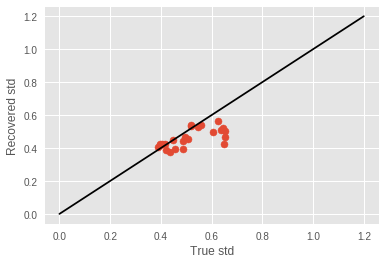

In [14]:
plt.scatter(upsilon,upsilon_hat)
plt.plot([0,1.2],[0,1.2],'k')
plt.xlabel('True std')
plt.ylabel('Recovered std')